In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

In [3]:
import pandas as pd
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi
import deepmatcher as dm
import torch

In [4]:
attributes =['Beer_Name','Brew_Factory_Name','Style','ABV']

In [5]:
model = dm.MatchingModel(attr_summarizer='hybrid')
model.load_state('../../models/beer_hybrid.pth')
model = model.cuda()

In [7]:
negatives = return_layer_input(model,model.classifier,'../../Structured/Beer/','negatives')


Reading and processing data from "../../Structured/Beer/negatives.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [9]:
positives = return_layer_input(model,model.classifier,'../../Structured/Beer','positives')


Reading and processing data from "../../Structured/Beer/positives.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [10]:
classifier_len = len(list(positives.values())[0])
attribute_len = int(classifier_len/len(attributes))

## Negative analysis

In [12]:
negatives_ri,neg_ri_norms = computeRi(model.classifier,attributes,negatives,1)
torch.save(negatives_ri,'experiment-results/neg_ri.pt')

100%|██████████| 382/382 [00:36<00:00, 10.54it/s]


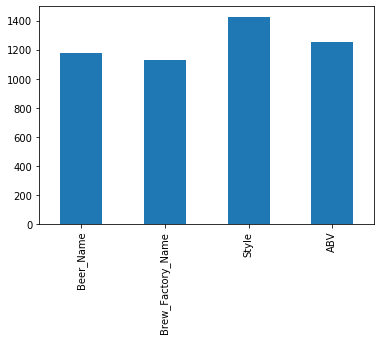

In [13]:
neg_ri_norms.sum().plot.bar()

## Positive analysis

In [15]:
positives_ri,pos_ri_norms = computeRi(model.classifier,attributes,positives,0)
torch.save(positives_ri,'experiment-results/pos_ri.pt')

100%|██████████| 68/68 [00:06<00:00, 11.27it/s]


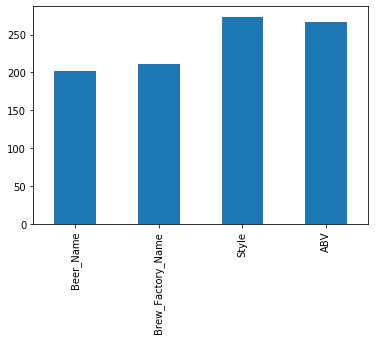

In [16]:
positives_variation_df = pd.DataFrame(data= pos_ri_norms,columns=attributes)
positives_variation_df.sum().plot.bar()

In [21]:
negatives_ri['0'][0]

tensor([-0.0070, -0.2417, -0.2052,  0.0281, -0.2106, -0.2640, -0.2396,  0.0713,
         0.1195,  0.1193,  0.4658,  0.5682, -0.6192, -0.4350,  0.1463,  0.2284,
        -0.2391,  0.0849, -0.0829, -0.2589, -0.1924,  0.0695,  0.1126,  0.2934,
         0.4449, -0.3749, -0.0177,  0.2620, -0.5592,  0.0168,  0.3129, -0.0240,
        -0.2641, -0.1386, -0.0722,  0.6645, -0.0175,  0.1266,  0.1473, -0.1867,
        -0.4915,  0.2370, -0.1949,  0.3873,  0.4896, -0.5174, -0.6400, -0.2088,
         0.2806,  0.1265, -0.4159,  0.0534, -0.1568,  0.0377,  0.5948, -0.5852,
        -0.2074,  0.1164, -0.0711, -0.4232, -0.5564, -0.0634, -0.3612,  0.2850,
        -0.0252,  0.3244, -0.2232, -0.0541, -0.1676,  0.0284, -0.0597,  0.2298,
         0.1394,  0.3209,  0.0858,  0.5130,  0.3076, -0.0048,  0.1507, -0.0163,
         0.2182, -0.1371, -0.0613,  0.2846,  0.1194, -0.2264,  0.4906, -0.3219,
         0.3741, -0.0811,  0.5085, -0.1348, -0.2102,  0.6990, -0.2847,  0.1321,
         0.3604,  0.2960,  0.3605,  0.01

## Compute closer vectors

### Considering all samples

In [25]:
from utils.distance_measures import nearestNeighborsOnAttribute

In [26]:
##run this cell to load precomputed ri
positives_ri = torch.load('experiment-results/pos_ri.pt')
negatives_ri = torch.load('experiment-results/neg_ri.pt')

In [38]:
positives_nn = nearestNeighborsOnAttribute(positives,positives_ri,
                                                       negatives,attributes,attribute_len)

100%|██████████| 68/68 [00:00<00:00, 479.39it/s]


In [39]:
negatives_nn = nearestNeighborsOnAttribute(negatives,negatives_ri,
                                                        positives,attributes,attribute_len)

100%|██████████| 382/382 [00:00<00:00, 586.79it/s]


In [29]:
positives_nn.to_csv('experiment-results/positivesNNhybrid.csv',index=False)
negatives_nn.to_csv('experiment-results/negativesNNhybrid.csv',index=False)

In [37]:
positives_nn.head(10)

,Beer_Name,Brew_Factory_Name,Style,ABV,SampleID
0,220,327,0,103,438
1,164,213,119,174,210
2,198,326,0,10,178
3,138,181,119,174,346
4,361,181,119,174,179
5,179,155,0,270,23
6,361,181,119,174,204
7,289,108,0,103,448
8,359,292,0,270,203
9,5,181,119,16,181


### Considering only training set

In [ ]:
train_neg = return_layer_input('../../Structured/Beer/','train_negatives',128,model,model.classifier)
train_pos = return_layer_input('../../Structured/Beer/','train_positives',128,model,model.classifier)

In [ ]:
positives_nn = calculate_nearest_neighbors_onAttributes(positives,positives_ri,
                                                       train_neg,attributes,attribute_len)

In [ ]:
negatives_nn = calculate_nearest_neighbors_onAttributes(negatives,negatives_ri,
                                                        train_pos,attributes,attribute_len)

In [ ]:
negatives_nn.to_csv('experiment-results/negativesNNhybrid_onlytrain.csv',index=False)
positives_nn.to_csv('experiment-results/positivesNNhybrid_onlytrain.csv',index=False)